In [2]:
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import datasets
from sklearn import svm 
import torch 
from sklearn.metrics import accuracy_score, roc_auc_score
from model_utils import calculate_accuracy 
import random 
import sklearn
SPLIT = True

%load_ext autoreload
%autoreload 2


c:\Users\Will\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Ensure that cuda is active. Set our device as the gpu. 

In [3]:
print(torch.cuda.is_available())

seed = 33  
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.benchmark = False


# device = torch.device('cuda')

True


Load in vascular ECM dataset

In [3]:
if SPLIT == False:
    data_set = datasets.load_dataset('mdeputy/fluorescent_lung_vascular_ECM',cache_dir="./data_sets")
else:
    data_set = datasets.load_dataset("./data_sets/mdeputy___fluorescent_lung_vascular_ecm")

Visualize first image to ensure we are working with the correct dataset. 

Image Type  RGB
Image Shape , (256, 256, 3)


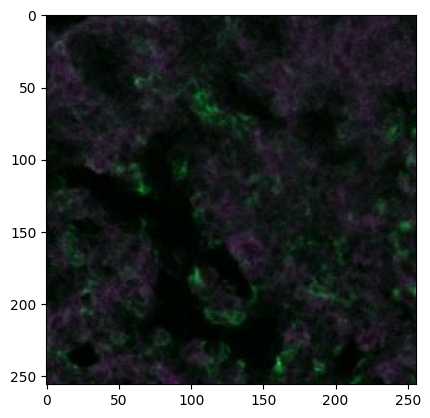

In [4]:
temp = data_set['train'][0]['image']
print('Image Type ', temp.mode )
as_array = np.array(temp)
print('Image Shape ,', as_array.shape)
plt.imshow(temp)
plt.show()



Now, make sure that images are in the correct format. Split into training, test, and validation sets.  Make sure we convert everything into numpy arrays, just for easier future access. 

In [73]:
num_samples = data_set.shape['train'][0]
print('Total Data Points',num_samples)

# training_num = np.floor(2*num_samples/3)
# x_train = np.random.choice(dataset)
if SPLIT == False:

    datasplit = data_set['train'].train_test_split(test_size=0.2)
    datasplit_val = datasplit['train'].train_test_split(test_size = 0.3)

    val = datasplit_val['test']
    datasplit_val['test'].save_to_disk('./data_sets/val')

    train = datasplit_val['train']
    datasplit_val['train'].save_to_disk('./data_sets/train')

    test = datasplit['test']
    datasplit['test'].save_to_disk('./data_sets/test')
    #got help with converting everything into the correct format
else:
    val = datasets.load_from_disk('./data_sets/val') 
    train = datasets.load_from_disk('./data_sets/train') 
    test = datasets.load_from_disk('./data_sets/test') 
    
x_train = np.array([np.array(sample) for sample in train['image']])
y_train = np.array([np.array(sample) for sample in train['class']])

x_val = np.array([np.array(sample) for sample in val['image']])
y_val = np.array([np.array(sample) for sample in val['class']])

x_test = np.array([np.array(sample) for sample in test['image']])
y_test = np.array([np.array(sample) for sample in test['class']])
    

print('training data size: ',train.shape)
print('validation data size: ,', val.shape)
print('testing data size: ', test.shape)







Total Data Points 1888
training data size:  (1057, 2)
validation data size: , (453, 2)
testing data size:  (378, 2)


In [6]:

temp=x_train[0:2].copy()
temp=temp.reshape(2,3,256,256)


x = torch.tensor(x_train[0:2],dtype=torch.float32)
if x.shape[1] != 3: 
    x = x.permute(0, 3, 1, 2)


temp=torch.tensor(temp,dtype=torch.float32)
are_equal = torch.equal(x,temp)
print(are_equal)

False


Preprocess Y to be values instead of strings

In [77]:

labels = {'CDH No Hernia':0, 'CDH with Hernia':1,'Control':2}
y_train =[labels[label] for label in y_train]
y_val = [labels[label] for label in y_val]
y_test = [labels[label] for label in y_test]

print(y_train[0:5])
print(y_val[0:5])
print(y_test[0:5])


[0, 1, 2, 2, 2]
[0, 1, 0, 2, 2]
[1, 2, 1, 0, 0]


Given a random output, what is the prediction? Total Baseline

In [8]:
np.random.seed(33)
size = len(y_val)
rand_prediction = np.random.randint(0,3,size)
correct= calculate_accuracy(rand_prediction,y_val)
print('Random Number Accuracy, Validation', correct)

Random Number Accuracy, Validation 0.3200883002207506


Establish Accuracy Baseline Using a linear classifier. Make sure we flatten data before pushing it through the SVM

In [9]:
num_samples = 300

x_train_svm = np.reshape(x_train, (x_train.shape[0], -1))
x_train_svm = x_train_svm[0:num_samples,:]
y_train_svm = y_train[0:num_samples]
x_test_svm = np.reshape(x_test, (x_test.shape[0], -1))
x_val_svm = np.reshape(x_val, (x_val.shape[0], -1))

simple_svm =svm.SVC(kernel='linear',verbose=True,probability=True)
simple_svm.fit(x_train_svm, y_train_svm)
predicted_val = simple_svm.predict(x_val_svm)
predicted_test = simple_svm.predict(x_test_svm)
predicted_test_ROC = simple_svm.predict_proba(x_test_svm)[:,1]
print(' ')
print('Baseline Validation Accuracy ', accuracy_score(predicted_val,y_val))
print('Baseline Test Accuracy',accuracy_score(predicted_test,y_test) )



[LibSVM] 
Baseline Validation Accuracy  0.38631346578366443
Baseline Test Accuracy 0.35185185185185186


Implement a basic CNN. Experimenting with Architecture is not the goal here, just making sure we have a working model for experimenting with data augmentation

In [ ]:
torch.cuda.empty_cache()
x_train_small = x_train
y_train_small = y_train
import time 

device='cpu'
start_time = time.time()

from model_utils import base_CNN
model = base_CNN()

trained_model,training_loss,val_loss = model.train_model(x_train_small,y_train_small,x_val,y_val,epochs=20,device=device,learning_rate=  0.00001)
stop_time = time.time()
print('Time To Train: ', stop_time-start_time)



Training Epoch 0/20
Current Loss:  1.5127428770065308
Training Epoch 1/20
Current Loss:  1.172511100769043
Training Epoch 2/20
Current Loss:  1.1933975219726562
Training Epoch 3/20
Current Loss:  1.132939338684082
Training Epoch 4/20
Current Loss:  1.1009870767593384
Training Epoch 5/20
Current Loss:  1.105448842048645
Training Epoch 6/20
Current Loss:  1.0989618301391602
Training Epoch 7/20
Current Loss:  1.0765575170516968
Training Epoch 8/20
Current Loss:  1.0589598417282104
Training Epoch 9/20
Current Loss:  1.0522021055221558
Training Epoch 10/20
Current Loss:  1.0454862117767334
Training Epoch 11/20
Current Loss:  1.0332318544387817
Training Epoch 12/20
Current Loss:  1.0184329748153687
Training Epoch 13/20
Current Loss:  1.0057697296142578
Training Epoch 14/20
Current Loss:  0.9989496469497681
Training Epoch 15/20
Current Loss:  0.9922787547111511
Training Epoch 16/20
Current Loss:  0.9816504120826721
Training Epoch 17/20
Current Loss:  0.9708605408668518
Training Epoch 18/20
Cu

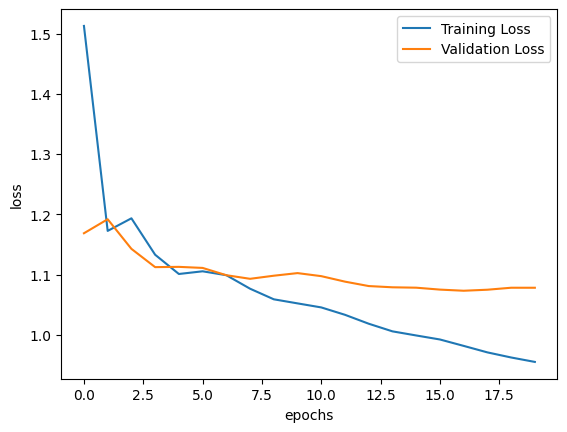

In [21]:
plt.plot(training_loss,label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [22]:
with torch.no_grad():
    predictions_max,predictions = model.predict(x_val,device=device)
    correct = calculate_accuracy(predictions_max,y_val)
print('Validation Accuracy ', correct )



Validation Accuracy  0.45695364238410596


In [23]:
with torch.no_grad():
    predictions_max,predictions = model.predict(x_test,device=device)
    correct = calculate_accuracy(predictions_max,y_test)
print('Test Accuracy ', correct )

Test Accuracy  0.47883597883597884


In [24]:
#Calculate ROC-AUC
roc_auc = roc_auc_score(y_test,predictions,multi_class='ovr')
print('ROC-AUC', roc_auc)

ROC-AUC 0.5583142413715033


Using an architecture designed for small datasets (see paper)

In [88]:
torch.cuda.empty_cache()
x_train_small = x_train
y_train_small = y_train
import time 

device='cpu'
start_time = time.time()

from model_utils import small_data_CNN
model = small_data_CNN()

trained_model,training_loss,val_loss = model.train_model(x_train_small,y_train_small,x_val,y_val,epochs=30,device=device,learning_rate= 0.01)
stop_time = time.time()
print('Time To Train: ', stop_time-start_time)

Training Epoch 0/30
Current Loss:  1.0974797010421753
Training Epoch 1/30
Current Loss:  1.1012756824493408
Training Epoch 2/30
Current Loss:  1.0830237865447998
Training Epoch 3/30
Current Loss:  1.0828344821929932
Training Epoch 4/30
Current Loss:  1.080749273300171
Training Epoch 5/30
Current Loss:  1.0782541036605835
Training Epoch 6/30
Current Loss:  1.0763332843780518
Training Epoch 7/30
Current Loss:  1.075154185295105
Training Epoch 8/30
Current Loss:  1.073489785194397
Training Epoch 9/30
Current Loss:  1.071435570716858
Training Epoch 10/30
Current Loss:  1.0682655572891235
Training Epoch 11/30
Current Loss:  1.0637764930725098
Training Epoch 12/30
Current Loss:  1.0582484006881714
Training Epoch 13/30
Current Loss:  1.0494627952575684
Training Epoch 14/30
Current Loss:  1.0361405611038208
Training Epoch 15/30
Current Loss:  1.0178561210632324
Training Epoch 16/30
Current Loss:  1.0062280893325806
Training Epoch 17/30
Current Loss:  1.0385947227478027
Training Epoch 18/30
Cur

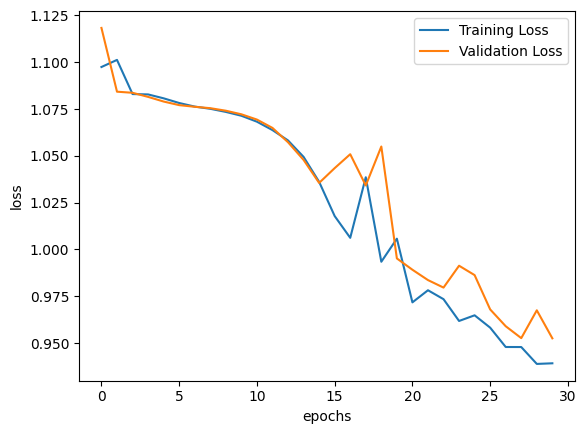

In [89]:
plt.plot(training_loss,label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [90]:
with torch.no_grad():
   predictions_max,predictions = model.predict(x_val,device=device)
   correct = calculate_accuracy(predictions_max,y_val)
print('Validation Accuracy ', correct )

Validation Accuracy  0.5783664459161147


In [91]:
with torch.no_grad():
    predictions_max,predictions = model.predict(x_test,device=device)
    correct = calculate_accuracy(predictions_max,y_test)
print('Test Accuracy ', correct )

Test Accuracy  0.5873015873015873


In [92]:
#Calculate ROC-AUC
roc_auc = roc_auc_score(y_test,predictions,multi_class='ovr')
print('ROC-AUC', roc_auc)

ROC-AUC 0.7101794761411581


Apply Transforms, retrain, and compute results 

In [ ]:
print(x_train.shape)


torch.cuda.empty_cache()
x_train_small = x_train
y_train_small = y_train
import time 

device='cpu'
start_time = time.time()

from model_utils import small_data_CNN
model = small_data_CNN()

trained_model,training_loss,val_loss = model.train_model(x_train_small,y_train_small,x_val,y_val,epochs=30,device=device,learning_rate=  0.01,augmentation='paper',add=True)
stop_time = time.time()
print('Time To Train: ', stop_time-start_time)



(1057, 256, 256, 3)


c:\Users\Will\Documents\DeepLearning\project\DL_project\augment_utils.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x,dtype=torch.float32)


Training Epoch 0/30
Current Loss:  1.097442388534546
Training Epoch 1/30
Current Loss:  1.0910292863845825
Training Epoch 2/30
Current Loss:  1.083315134048462
Training Epoch 3/30
Current Loss:  1.081994652748108
Training Epoch 4/30
Current Loss:  1.0793646574020386
Training Epoch 5/30
Current Loss:  1.076528787612915
Training Epoch 6/30
Current Loss:  1.074194073677063
Training Epoch 7/30
Current Loss:  1.0730743408203125
Training Epoch 8/30
Current Loss:  1.0718811750411987
Training Epoch 9/30
Current Loss:  1.0682182312011719
Training Epoch 10/30
Current Loss:  1.0619969367980957
Training Epoch 11/30
Current Loss:  1.0505130290985107
Training Epoch 12/30
Current Loss:  1.0352911949157715
Training Epoch 13/30
Current Loss:  1.0208553075790405
Training Epoch 14/30
Current Loss:  1.0338373184204102
Training Epoch 15/30
Current Loss:  1.0480695962905884
Training Epoch 16/30
Current Loss:  1.0286482572555542
Training Epoch 17/30
Current Loss:  0.9979084134101868
Training Epoch 18/30
Curr

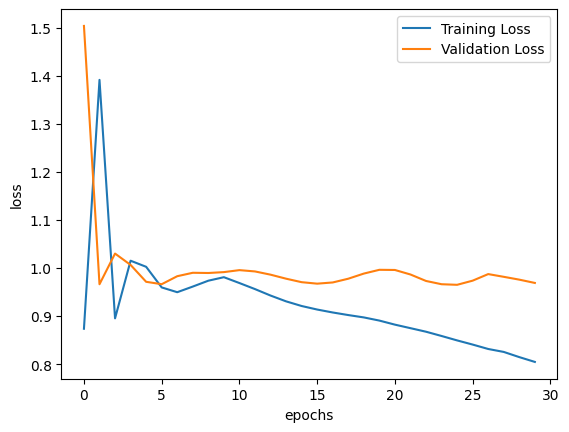

In [113]:
plt.plot(training_loss,label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim(1.0,1.2)
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [114]:
with torch.no_grad():
   predictions_max,predictions = model.predict(x_val,device=device)
   correct = calculate_accuracy(predictions_max,y_val)
print('Validation Accuracy ', correct )



with torch.no_grad():
    predictions_max,predictions = model.predict(x_test,device=device)
    correct = calculate_accuracy(predictions_max,y_test)
print('Test Accuracy ', correct )


roc_auc = roc_auc_score(y_test,predictions,multi_class='ovr')
print('ROC-AUC', roc_auc)

Validation Accuracy  0.5607064017660044
Test Accuracy  0.5767195767195767
ROC-AUC 0.7541808572616814


In [115]:
print(x_train.shape)


torch.cuda.empty_cache()
x_train_small = x_train
y_train_small = y_train
import time 

device='cpu'
start_time = time.time()

from model_utils import small_data_CNN
model = small_data_CNN()

trained_model,training_loss,val_loss = model.train_model(x_train_small,y_train_small,x_val,y_val,epochs=30,device=device,learning_rate=  0.005,augmentation='paper',add=True)
stop_time = time.time()
print('Time To Train: ', stop_time-start_time)

(1057, 256, 256, 3)


c:\Users\Will\Documents\DeepLearning\project\DL_project\augment_utils.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x,dtype=torch.float32)


Training Epoch 0/30
Current Loss:  1.0975507497787476
Training Epoch 1/30
Current Loss:  1.082865595817566
Training Epoch 2/30
Current Loss:  1.1134259700775146
Training Epoch 3/30
Current Loss:  1.0766583681106567
Training Epoch 4/30
Current Loss:  1.0803298950195312
Training Epoch 5/30
Current Loss:  1.0815783739089966
Training Epoch 6/30
Current Loss:  1.0813392400741577
Training Epoch 7/30
Current Loss:  1.0804338455200195
Training Epoch 8/30
Current Loss:  1.0790497064590454
Training Epoch 9/30
Current Loss:  1.077104926109314
Training Epoch 10/30
Current Loss:  1.0743210315704346
Training Epoch 11/30
Current Loss:  1.0705846548080444
Training Epoch 12/30
Current Loss:  1.0676347017288208
Training Epoch 13/30
Current Loss:  1.0644062757492065
Training Epoch 14/30
Current Loss:  1.0613062381744385
Training Epoch 15/30
Current Loss:  1.0575706958770752
Training Epoch 16/30
Current Loss:  1.051497459411621
Training Epoch 17/30
Current Loss:  1.0451807975769043
Training Epoch 18/30
Cu

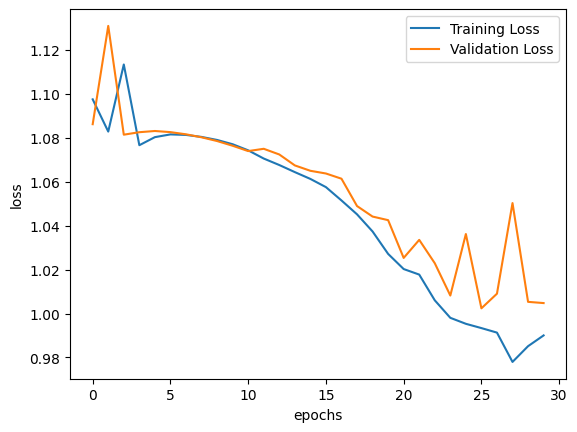

In [116]:
plt.plot(training_loss,label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim(1.0,1.2)
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [117]:
with torch.no_grad():
   predictions_max,predictions = model.predict(x_val,device=device)
   correct = calculate_accuracy(predictions_max,y_val)
print('Validation Accuracy ', correct )



with torch.no_grad():
    predictions_max,predictions = model.predict(x_test,device=device)
    correct = calculate_accuracy(predictions_max,y_test)
print('Test Accuracy ', correct )


roc_auc = roc_auc_score(y_test,predictions,multi_class='ovr')
print('ROC-AUC', roc_auc)

Validation Accuracy  0.5231788079470199
Test Accuracy  0.5264550264550265
ROC-AUC 0.6835040111384186


### We now want to optimize our augmentations

__________________________________________
Testing:  randomFlip_Hoz
23.107053777766282


c:\Users\Will\Documents\DeepLearning\project\DL_project\augment_utils.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x,dtype=torch.float32)


Training Epoch 0/30
Current Loss:  1.0974797010421753
Training Epoch 1/30
Current Loss:  1.1012756824493408
Training Epoch 2/30
Current Loss:  1.0830237865447998
Training Epoch 3/30
Current Loss:  1.082834243774414
Training Epoch 4/30
Current Loss:  1.080749273300171
Training Epoch 5/30
Current Loss:  1.0782554149627686
Training Epoch 6/30
Current Loss:  1.0763356685638428
Training Epoch 7/30
Current Loss:  1.075178623199463
Training Epoch 8/30
Current Loss:  1.0735297203063965
Training Epoch 9/30
Current Loss:  1.0714408159255981
Training Epoch 10/30
Current Loss:  1.0682374238967896
Training Epoch 11/30
Current Loss:  1.063905954360962
Training Epoch 12/30
Current Loss:  1.0587693452835083
Training Epoch 13/30
Current Loss:  1.0506967306137085
Training Epoch 14/30
Current Loss:  1.0381118059158325
Training Epoch 15/30
Current Loss:  1.021540641784668
Training Epoch 16/30
Current Loss:  1.0174570083618164
Training Epoch 17/30
Current Loss:  1.0244954824447632
Training Epoch 18/30
Curr

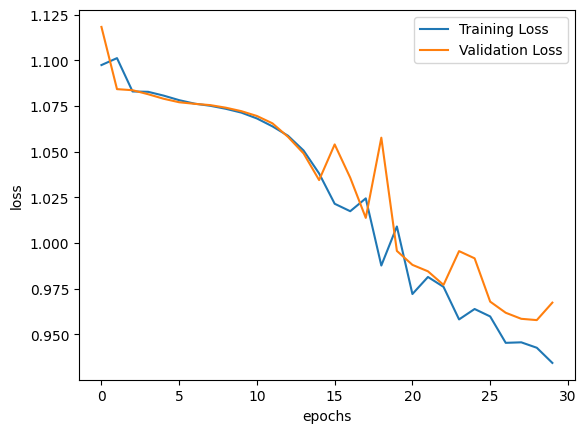

__________________________________________
__________________________________________
Testing:  randomFlip_Vert
23.107053777766282


c:\Users\Will\Documents\DeepLearning\project\DL_project\augment_utils.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x,dtype=torch.float32)


Training Epoch 0/30
Current Loss:  0.9331488013267517
Training Epoch 1/30
Current Loss:  1.270262598991394
Training Epoch 2/30
Current Loss:  0.9577360153198242
Training Epoch 3/30
Current Loss:  1.0194483995437622
Training Epoch 4/30
Current Loss:  1.0303266048431396
Training Epoch 5/30
Current Loss:  1.0116690397262573
Training Epoch 6/30
Current Loss:  1.0077718496322632
Training Epoch 7/30
Current Loss:  1.0022190809249878
Training Epoch 8/30
Current Loss:  0.9928128719329834
Training Epoch 9/30
Current Loss:  0.9822918176651001
Training Epoch 10/30
Current Loss:  0.9706414341926575
Training Epoch 11/30
Current Loss:  0.9610745906829834
Training Epoch 12/30
Current Loss:  0.9551847577095032
Training Epoch 13/30
Current Loss:  0.9500083923339844
Training Epoch 14/30
Current Loss:  0.9479910731315613
Training Epoch 15/30
Current Loss:  0.9496321082115173
Training Epoch 16/30
Current Loss:  0.9450855255126953
Training Epoch 17/30
Current Loss:  0.9409180879592896
Training Epoch 18/30


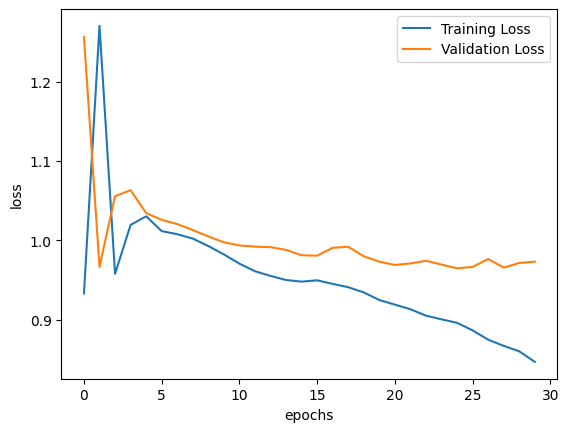

__________________________________________
__________________________________________
Testing:  randomRotation
23.107053777766282


c:\Users\Will\Documents\DeepLearning\project\DL_project\augment_utils.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x,dtype=torch.float32)


Training Epoch 0/30
Current Loss:  0.8979505896568298
Training Epoch 1/30
Current Loss:  1.04355788230896
Training Epoch 2/30
Current Loss:  1.0625672340393066
Training Epoch 3/30
Current Loss:  0.9524718523025513
Training Epoch 4/30
Current Loss:  0.9398460984230042
Training Epoch 5/30
Current Loss:  0.9429761171340942
Training Epoch 6/30
Current Loss:  0.9176433086395264
Training Epoch 7/30
Current Loss:  0.9227157235145569
Training Epoch 8/30
Current Loss:  0.926477313041687
Training Epoch 9/30
Current Loss:  0.9153892397880554
Training Epoch 10/30
Current Loss:  0.9127340316772461
Training Epoch 11/30
Current Loss:  0.9093785285949707
Training Epoch 12/30
Current Loss:  0.8959947824478149
Training Epoch 13/30
Current Loss:  0.8884761333465576
Training Epoch 14/30
Current Loss:  0.8837798833847046
Training Epoch 15/30
Current Loss:  0.8787078857421875
Training Epoch 16/30
Current Loss:  0.8729462027549744
Training Epoch 17/30
Current Loss:  0.8675913214683533
Training Epoch 18/30
Cu

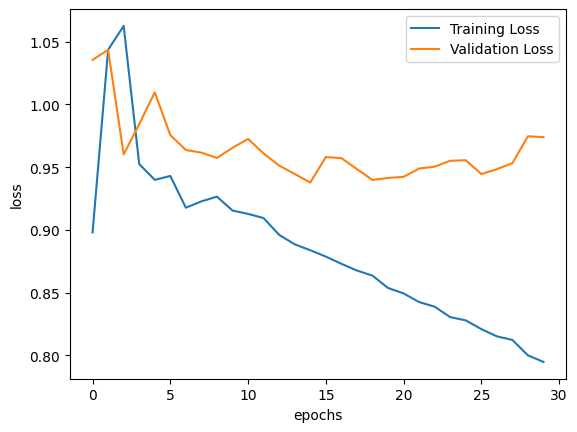

__________________________________________
__________________________________________
Testing:  randomResizeCrop
23.107053777766282


c:\Users\Will\Documents\DeepLearning\project\DL_project\augment_utils.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x,dtype=torch.float32)


Training Epoch 0/30
Current Loss:  0.8022276759147644
Training Epoch 1/30
Current Loss:  2.0619804859161377
Training Epoch 2/30
Current Loss:  1.0203642845153809
Training Epoch 3/30
Current Loss:  0.925474226474762
Training Epoch 4/30
Current Loss:  0.9811062216758728
Training Epoch 5/30
Current Loss:  0.9878728985786438
Training Epoch 6/30
Current Loss:  0.9871784448623657
Training Epoch 7/30
Current Loss:  0.9912378191947937
Training Epoch 8/30
Current Loss:  0.9823787808418274
Training Epoch 9/30
Current Loss:  0.9805890917778015
Training Epoch 10/30
Current Loss:  0.9759437441825867
Training Epoch 11/30
Current Loss:  0.9683777689933777
Training Epoch 12/30
Current Loss:  0.9612016677856445
Training Epoch 13/30
Current Loss:  0.9541669487953186
Training Epoch 14/30
Current Loss:  0.9433696269989014
Training Epoch 15/30
Current Loss:  0.9309521913528442
Training Epoch 16/30
Current Loss:  0.9194662570953369
Training Epoch 17/30
Current Loss:  0.9070509672164917
Training Epoch 18/30


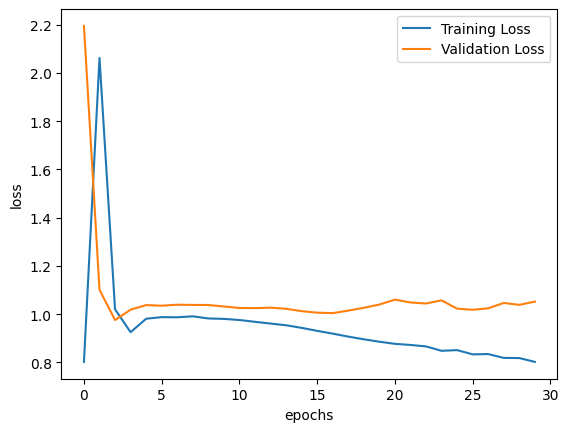

__________________________________________
__________________________________________
Testing:  affine
23.107053777766282


c:\Users\Will\Documents\DeepLearning\project\DL_project\augment_utils.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x,dtype=torch.float32)


Training Epoch 0/30
Current Loss:  0.8736525177955627
Training Epoch 1/30
Current Loss:  1.3912031650543213
Training Epoch 2/30
Current Loss:  0.8953081369400024
Training Epoch 3/30
Current Loss:  1.015140414237976
Training Epoch 4/30
Current Loss:  1.0024733543395996
Training Epoch 5/30
Current Loss:  0.9595909714698792
Training Epoch 6/30
Current Loss:  0.9496445059776306
Training Epoch 7/30
Current Loss:  0.9613628387451172
Training Epoch 8/30
Current Loss:  0.9735780954360962
Training Epoch 9/30
Current Loss:  0.9808672070503235
Training Epoch 10/30
Current Loss:  0.9686857461929321
Training Epoch 11/30
Current Loss:  0.956131100654602
Training Epoch 12/30
Current Loss:  0.9427002668380737
Training Epoch 13/30
Current Loss:  0.9306234121322632
Training Epoch 14/30
Current Loss:  0.9209522604942322
Training Epoch 15/30
Current Loss:  0.9136013984680176
Training Epoch 16/30
Current Loss:  0.9074832797050476
Training Epoch 17/30
Current Loss:  0.902119517326355
Training Epoch 18/30
Cu

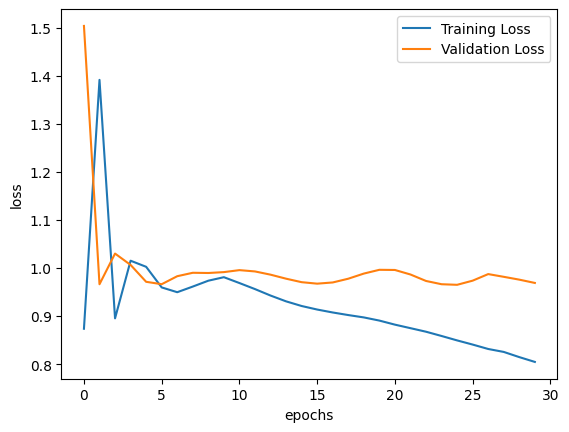

__________________________________________
__________________________________________
Testing:  gaussian
23.107053777766282


c:\Users\Will\Documents\DeepLearning\project\DL_project\augment_utils.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x,dtype=torch.float32)


Training Epoch 0/30
Current Loss:  0.7761538028717041
Training Epoch 1/30
Current Loss:  1.0913985967636108
Training Epoch 2/30
Current Loss:  0.9322075247764587
Training Epoch 3/30
Current Loss:  0.8145410418510437
Training Epoch 4/30
Current Loss:  0.8429129123687744
Training Epoch 5/30
Current Loss:  0.841795027256012
Training Epoch 6/30
Current Loss:  0.8379108905792236
Training Epoch 7/30
Current Loss:  0.8381026983261108
Training Epoch 8/30
Current Loss:  0.8318479061126709
Training Epoch 9/30
Current Loss:  0.8178465366363525
Training Epoch 10/30
Current Loss:  0.8101106286048889
Training Epoch 11/30
Current Loss:  0.799988329410553
Training Epoch 12/30
Current Loss:  0.7860835790634155
Training Epoch 13/30
Current Loss:  0.7822860479354858
Training Epoch 14/30
Current Loss:  0.768503725528717
Training Epoch 15/30
Current Loss:  0.7657273411750793
Training Epoch 16/30
Current Loss:  0.7441264986991882
Training Epoch 17/30
Current Loss:  0.7345290184020996
Training Epoch 18/30
Cu

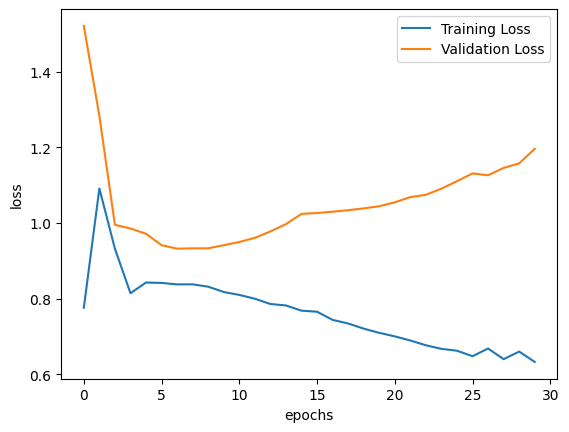

__________________________________________
Time To Train:  1489.2073397636414


In [118]:
augmentations = ['randomFlip_Hoz','randomFlip_Vert','randomRotation','randomResizeCrop','affine','gaussian']

torch.cuda.empty_cache()
x_train_small = x_train
y_train_small = y_train
import time 

device='cpu'
start_time = time.time()

from model_utils import small_data_CNN
model = small_data_CNN()
for val in augmentations:
    print('__________________________________________')
    print('Testing: ',val)
    print(np.mean(x_train_small))
    trained_model,training_loss,val_loss = model.train_model(x_train_small,y_train_small,x_val,y_val,epochs=30,device=device,learning_rate=  0.01,augmentation=val, add=True)
    trained_model.calculate_accuracy_full(x_test,y_test,x_val,y_val)
    plt.plot(training_loss,label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    # plt.ylim(1.0,1.2)
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.show()
    print('__________________________________________')
stop_time = time.time()
print('Time To Train: ', stop_time-start_time)

## Best Combination (Top 3)

__________________________________________
Testing Best
Training Epoch 0/30
Current Loss:  1.0978381633758545
Training Epoch 1/30
Current Loss:  1.089342474937439
Training Epoch 2/30
Current Loss:  1.0824217796325684
Training Epoch 3/30
Current Loss:  1.0811381340026855
Training Epoch 4/30
Current Loss:  1.0781102180480957
Training Epoch 5/30
Current Loss:  1.0752357244491577
Training Epoch 6/30
Current Loss:  1.073447823524475
Training Epoch 7/30
Current Loss:  1.0732792615890503
Training Epoch 8/30
Current Loss:  1.0700739622116089
Training Epoch 9/30
Current Loss:  1.0669788122177124
Training Epoch 10/30
Current Loss:  1.059634804725647
Training Epoch 11/30
Current Loss:  1.046924114227295
Training Epoch 12/30
Current Loss:  1.0309054851531982
Training Epoch 13/30
Current Loss:  1.037142276763916
Training Epoch 14/30
Current Loss:  1.0097330808639526
Training Epoch 15/30
Current Loss:  1.0188682079315186
Training Epoch 16/30
Current Loss:  1.0251104831695557
Training Epoch 17/30
Cur

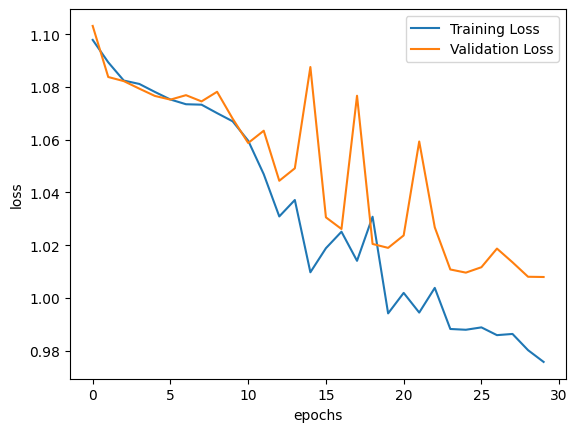

__________________________________________
Time To Train:  638.0558259487152


In [125]:

torch.cuda.empty_cache()
x_train_small = x_train
y_train_small = y_train
import time 

device='cpu'
start_time = time.time()

from model_utils import small_data_CNN
model = small_data_CNN()

print('__________________________________________')
print('Testing Best')
trained_model,training_loss,val_loss = model.train_model(x_train_small,y_train_small,x_val,y_val,epochs=30,device=device,learning_rate=  0.01,augmentation='best', add=True)
trained_model.calculate_accuracy_full(x_test,y_test,x_val,y_val)
plt.plot(training_loss,label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim(1.0,1.2)
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()
print('__________________________________________')
stop_time = time.time()
print('Time To Train: ', stop_time-start_time)

## now, adjust sample size and see how low we can go

__________________________________________
Testing Best


c:\Users\Will\Documents\DeepLearning\project\DL_project\augment_utils.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x,dtype=torch.float32)


Training Epoch 0/45
Current Loss:  1.0981254577636719
Training Epoch 1/45
Current Loss:  1.1106367111206055
Training Epoch 2/45
Current Loss:  1.0888227224349976
Training Epoch 3/45
Current Loss:  1.0880546569824219
Training Epoch 4/45
Current Loss:  1.0866093635559082
Training Epoch 5/45
Current Loss:  1.0853426456451416
Training Epoch 6/45
Current Loss:  1.084637999534607
Training Epoch 7/45
Current Loss:  1.0841588973999023
Training Epoch 8/45
Current Loss:  1.0831689834594727
Training Epoch 9/45
Current Loss:  1.0834516286849976
Training Epoch 10/45
Current Loss:  1.0796973705291748
Training Epoch 11/45
Current Loss:  1.074668526649475
Training Epoch 12/45
Current Loss:  1.0680713653564453
Training Epoch 13/45
Current Loss:  1.0599143505096436
Training Epoch 14/45
Current Loss:  1.0461604595184326
Training Epoch 15/45
Current Loss:  1.0317736864089966
Training Epoch 16/45
Current Loss:  1.0282645225524902
Training Epoch 17/45
Current Loss:  1.0746711492538452
Training Epoch 18/45
C

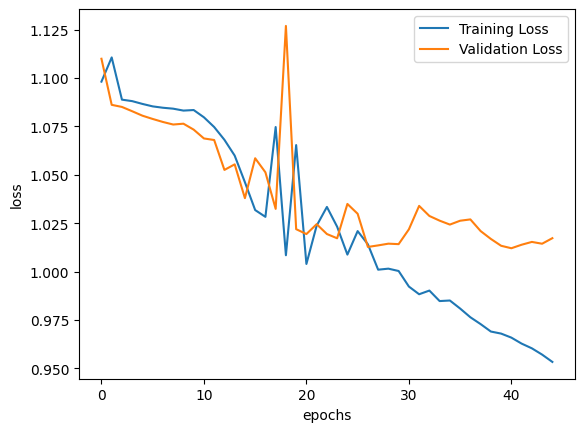

__________________________________________
Time To Train:  446.44758796691895


In [126]:
torch.cuda.empty_cache()
index = np.random.permutation(len(x_train))
half_size = len(x_train)//2
index = index[:half_size]
x_train_small = x_train[index]
y_train_small = np.array(y_train)
y_train_small = y_train_small[index]

import time 

device='cpu'
start_time = time.time()

from model_utils import small_data_CNN
model = small_data_CNN()

print('__________________________________________')
print('Testing Best')
trained_model,training_loss,val_loss = model.train_model(x_train_small,y_train_small,x_val,y_val,epochs=45,device=device,learning_rate=  0.01,augmentation='best', add=True)
trained_model.calculate_accuracy_full(x_test,y_test,x_val,y_val)
plt.plot(training_loss,label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim(1.0,1.2)
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()
print('__________________________________________')
stop_time = time.time()
print('Time To Train: ', stop_time-start_time)

__________________________________________
Testing Best
Training Epoch 0/45
Current Loss:  1.0976120233535767
Training Epoch 1/45
Current Loss:  1.1321125030517578
Training Epoch 2/45
Current Loss:  1.0889933109283447
Training Epoch 3/45
Current Loss:  1.0887975692749023
Training Epoch 4/45
Current Loss:  1.0873844623565674
Training Epoch 5/45
Current Loss:  1.0860130786895752
Training Epoch 6/45
Current Loss:  1.0850869417190552
Training Epoch 7/45
Current Loss:  1.0845593214035034
Training Epoch 8/45
Current Loss:  1.0840868949890137
Training Epoch 9/45
Current Loss:  1.083346962928772
Training Epoch 10/45
Current Loss:  1.082511067390442
Training Epoch 11/45
Current Loss:  1.0813781023025513
Training Epoch 12/45
Current Loss:  1.0794721841812134
Training Epoch 13/45
Current Loss:  1.0758233070373535
Training Epoch 14/45
Current Loss:  1.0713170766830444
Training Epoch 15/45
Current Loss:  1.062065839767456
Training Epoch 16/45
Current Loss:  1.0475784540176392
Training Epoch 17/45
C

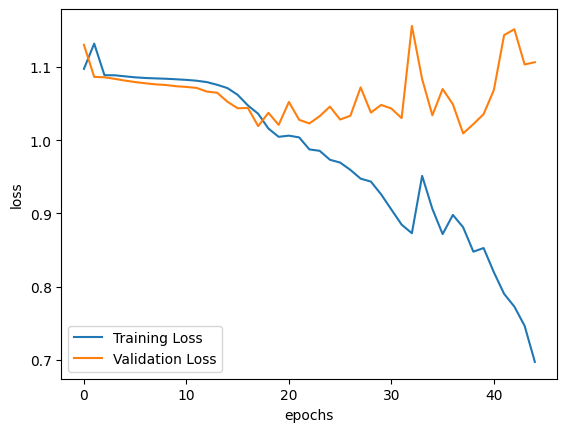

__________________________________________
Time To Train:  98.74967408180237


In [127]:
torch.cuda.empty_cache()
index = np.random.permutation(len(x_train))
half_size = len(x_train)//2
index = index[:half_size]
x_train_small = x_train[index]
y_train_small = np.array(y_train)
y_train_small = y_train_small[index]

import time 

device='cpu'
start_time = time.time()

from model_utils import small_data_CNN
model = small_data_CNN()

print('__________________________________________')
print('Testing Best')
trained_model,training_loss,val_loss = model.train_model(x_train_small,y_train_small,x_val,y_val,epochs=45,device=device,learning_rate=  0.01)
trained_model.calculate_accuracy_full(x_test,y_test,x_val,y_val)
plt.plot(training_loss,label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim(1.0,1.2)
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()
print('__________________________________________')
stop_time = time.time()
print('Time To Train: ', stop_time-start_time)

## Now Apply To Blood Vessel Dataset

In [4]:
import os
bv_dataset=[]

filepath = '.\\blood_vessel_images\\ctrl\\'
#use os library to access each image that we will be reading in. Read in using imread. 

for file in os.listdir(filepath):
    if file[-3:]=='tif':
        bv_dataset.append(io.imread(filepath+file))


filepath = '.\\blood_vessel_images\\hr\\'
for file in os.listdir(filepath):
    if file[-3:]=='tif':
        bv_dataset.append(io.imread(filepath+file))


filepath = '.\\blood_vessel_images\\qs\\'
for file in os.listdir(filepath):
    if file[-3:]=='tif':
        bv_dataset.append(io.imread(filepath+file))




In [21]:
import sklearn



labels = [0] * 8 + [1] * 10 + [2] * 10
bv_dataset = np.array(bv_dataset)

bv_x_train, bv_x_test, bv_y_train, bv_y_test = sklearn.model_selection.train_test_split(
    bv_dataset, labels, test_size=0.3, stratify=labels, random_state=42
)
bv_x_train = torch.tensor(bv_x_train,dtype=torch.float32)
bv_x_train = bv_x_train.permute(0, 3, 1, 2)
bv_x_test = torch.tensor(bv_x_test,dtype=torch.float32)
bv_x_test = bv_x_test.permute(0, 3, 1, 2)
import torch.nn.functional as F

bv_x_train = F.interpolate(bv_x_train, size=(256, 256), mode='bilinear', align_corners=False)
bv_x_test = F.interpolate(bv_x_test, size=(256, 256), mode='bilinear', align_corners=False)

bv_x_val = bv_x_train
bv_y_val = bv_y_train

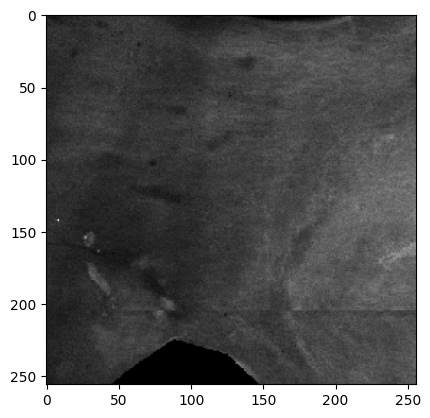

In [46]:
import matplotlib.pyplot as plt
import io
plt.imshow(bv_x_train[0,2,:,:],cmap='gray')


In [22]:

print(bv_dataset.shape)
print(bv_x_train.shape)

(28, 1675, 1675, 3)
torch.Size([19, 3, 256, 256])


__________________________________________
Testing Best
Training Epoch 0/45


c:\Users\Will\Documents\DeepLearning\project\DL_project\model_utils.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x,dtype=torch.float32)
c:\Users\Will\Documents\DeepLearning\project\DL_project\augment_utils.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x,dtype=torch.float32)
c:\Users\Will\Documents\DeepLearning\project\DL_project\model_utils.py:218: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val = torch.tensor(x_val, dtype=torch.float32).to(device)


Current Loss:  1.1023015975952148
Training Epoch 1/45
Current Loss:  1.0577186346054077
Training Epoch 2/45
Current Loss:  1.3198158740997314
Training Epoch 3/45
Current Loss:  1.0352438688278198
Training Epoch 4/45
Current Loss:  1.0600663423538208
Training Epoch 5/45
Current Loss:  1.0540436506271362
Training Epoch 6/45
Current Loss:  1.0360372066497803
Training Epoch 7/45
Current Loss:  1.006600022315979
Training Epoch 8/45
Current Loss:  0.9824005961418152
Training Epoch 9/45
Current Loss:  0.9518641233444214
Training Epoch 10/45
Current Loss:  0.9331514239311218
Training Epoch 11/45
Current Loss:  1.1003923416137695
Training Epoch 12/45
Current Loss:  0.9770726561546326
Training Epoch 13/45
Current Loss:  1.051985263824463
Training Epoch 14/45
Current Loss:  1.0829895734786987
Training Epoch 15/45
Current Loss:  1.0905474424362183
Training Epoch 16/45
Current Loss:  1.0839548110961914
Training Epoch 17/45
Current Loss:  1.062808871269226
Training Epoch 18/45
Current Loss:  1.02831

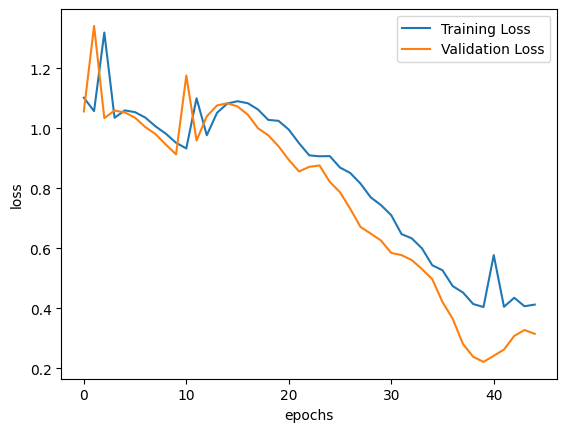

__________________________________________
Time To Train:  13.36647891998291


In [38]:
torch.cuda.empty_cache()

import time 

device='cpu'
start_time = time.time()

from model_utils import small_data_CNN
model = small_data_CNN()



print('__________________________________________')
print('Testing Best')
trained_model,training_loss,val_loss = model.train_model(bv_x_train,bv_y_train,bv_x_val,bv_y_val,epochs=45,device=device,learning_rate=  0.01,augmentation='best', add=True)
trained_model.calculate_accuracy_full(bv_x_test,bv_y_test,bv_x_val,bv_y_val)
plt.plot(training_loss,label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim(1.0,1.2)
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()
print('__________________________________________')
stop_time = time.time()
print('Time To Train: ', stop_time-start_time)

c:\Users\Will\Documents\DeepLearning\project\DL_project\model_utils.py:204: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x,dtype=torch.float32)


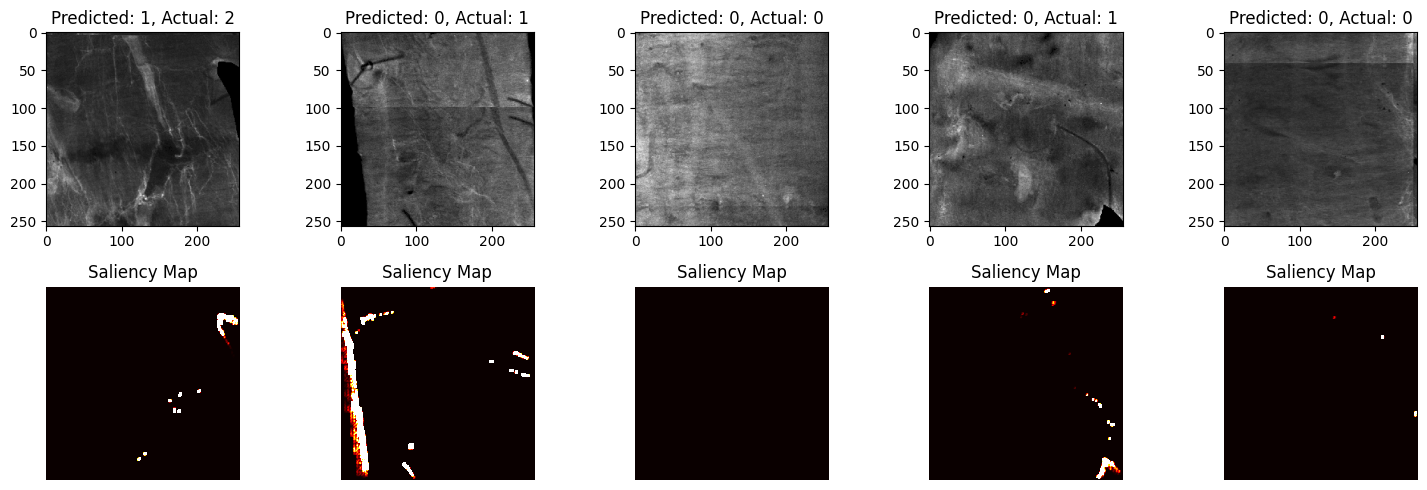

In [73]:
model.visualize_output(bv_x_test,bv_y_test)

__________________________________________
Testing Best
Training Epoch 0/45
Current Loss:  1.1016336679458618
Training Epoch 1/45
Current Loss:  1.0567229986190796
Training Epoch 2/45


c:\Users\Will\Documents\DeepLearning\project\DL_project\model_utils.py:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x,dtype=torch.float32)
c:\Users\Will\Documents\DeepLearning\project\DL_project\model_utils.py:217: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val = torch.tensor(x_val, dtype=torch.float32).to(device)


Current Loss:  1.2676197290420532
Training Epoch 3/45
Current Loss:  1.0305880308151245
Training Epoch 4/45
Current Loss:  1.0705925226211548
Training Epoch 5/45
Current Loss:  1.0759884119033813
Training Epoch 6/45
Current Loss:  1.0705152750015259
Training Epoch 7/45
Current Loss:  1.0610220432281494
Training Epoch 8/45
Current Loss:  1.0473697185516357
Training Epoch 9/45
Current Loss:  1.0260744094848633
Training Epoch 10/45
Current Loss:  0.9842897653579712
Training Epoch 11/45
Current Loss:  0.9295786023139954
Training Epoch 12/45
Current Loss:  1.0202265977859497
Training Epoch 13/45
Current Loss:  0.8608667254447937
Training Epoch 14/45
Current Loss:  0.9030560851097107
Training Epoch 15/45
Current Loss:  0.8807003498077393
Training Epoch 16/45
Current Loss:  0.8107446432113647
Training Epoch 17/45
Current Loss:  0.7088066935539246
Training Epoch 18/45
Current Loss:  0.7272487878799438
Training Epoch 19/45
Current Loss:  0.6533553600311279
Training Epoch 20/45
Current Loss:  0.

c:\Users\Will\Documents\DeepLearning\project\DL_project\model_utils.py:203: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x,dtype=torch.float32)


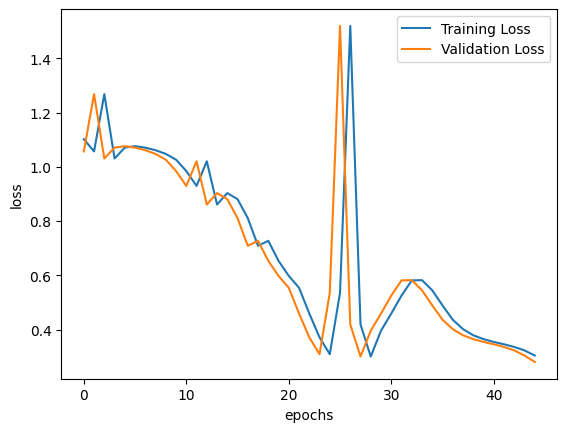

__________________________________________
Time To Train:  3.52405047416687


In [26]:
torch.cuda.empty_cache()

import time 

device='cpu'
start_time = time.time()

from model_utils import small_data_CNN
model = small_data_CNN()



print('__________________________________________')
print('Testing Best')
trained_model,training_loss,val_loss = model.train_model(bv_x_train,bv_y_train,bv_x_val,bv_y_val,epochs=45,device=device,learning_rate=0.01)
trained_model.calculate_accuracy_full(bv_x_test,bv_y_test,bv_x_val,bv_y_val)
plt.plot(training_loss,label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim(1.0,1.2)
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()
print('__________________________________________')
stop_time = time.time()
print('Time To Train: ', stop_time-start_time)